In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(42)

In [ ]:
class TextPreprocessor:
    def __init__(self):

        self.url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        self.mention_pattern = re.compile(r'@[A-Za-z0-9_]+')
        self.hashtag_pattern = re.compile(r'#[A-Za-z0-9_]+')
        self.email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
        self.phone_pattern = re.compile(r'[\+]?[1-9]?[0-9]{7,12}')
        self.number_pattern = re.compile(r'\b\d+\b')

    def clean_text(self, text):

        if pd.isna(text):
            return ""

        text = str(text).lower()

        # Remove URLs, mentions, hashtags, emails, phone numbers
        text = self.url_pattern.sub(' URL ', text)
        text = self.mention_pattern.sub(' MENTION ', text)
        text = self.hashtag_pattern.sub(' HASHTAG ', text)
        text = self.email_pattern.sub(' EMAIL ', text)
        text = self.phone_pattern.sub(' PHONE ', text)

        # Handle repeated characters (common in social media)
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)

        # Remove special characters but keep Devanagari and other Indian scripts
        text = re.sub(r'[^\w\s\u0900-\u097F\u0980-\u09FF\u0A00-\u0A7F\u0A80-\u0AFF\u0B00-\u0B7F\u0B80-\u0BFF\u0C00-\u0C7F\u0C80-\u0CFF\u0D00-\u0D7F]', ' ', text)

        return text.strip()

    def preprocess_batch(self, texts):

        return [self.clean_text(text) for text in texts]

preprocessor = TextPreprocessor()

In [ ]:
class DataLoader:
    def __init__(self, language):
        self.language = language
        self.train_data = None
        self.dev_data = None
        self.test_data = None
        self.label_encoder = LabelEncoder()
        self.unique_labels = None

    def load_data(self, train_path, dev_path, test_path):
        try:
            self.train_data = pd.read_csv(train_path)
            self.dev_data = pd.read_csv(dev_path)
            self.test_data = pd.read_csv(test_path)

            print(f"Data loaded for {self.language}")
            print(f"Train shape: {self.train_data.shape}")
            print(f"Dev shape: {self.dev_data.shape}")
            print(f"Test shape: {self.test_data.shape}")

            # Display label distribution
            self.explore_labels()

        except Exception as e:
            print(f" Error loading data for {self.language}: {e}")

    def explore_labels(self):

        if self.train_data is not None:
            print(f"\nLabel distribution for {self.language}:")
            label_counts = self.train_data['Labels'].value_counts()
            print(label_counts)

            # Store unique labels
            self.unique_labels = sorted(self.train_data['Labels'].unique())
            print(f"\nUnique labels: {self.unique_labels}")

    def preprocess_text_data(self):
        if self.train_data is not None:
            print(f" Preprocessing text for {self.language}...")

            # Preprocess text
            self.train_data['Text_clean'] = preprocessor.preprocess_batch(self.train_data['Text'])
            self.dev_data['Text_clean'] = preprocessor.preprocess_batch(self.dev_data['Text'])
            self.test_data['Text_clean'] = preprocessor.preprocess_batch(self.test_data['Text'])

            # Remove empty texts
            self.train_data = self.train_data[self.train_data['Text_clean'].str.len() > 0]
            self.dev_data = self.dev_data[self.dev_data['Text_clean'].str.len() > 0]

            print(f"Text preprocessing completed for {self.language}")
            print(f"Train samples after cleaning: {len(self.train_data)}")
            print(f"Dev samples after cleaning: {len(self.dev_data)}")

In [ ]:
class OffensiveLanguageModel:
    def __init__(self, vocab_size, embedding_dim=128, max_length=100, num_classes=6):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.num_classes = num_classes
        self.model = None
        self.tokenizer = None

    def build_lstm_model(self):
        model = keras.Sequential([
            layers.Embedding(self.vocab_size, self.embedding_dim, input_length=self.max_length),
            layers.SpatialDropout1D(0.2),
            layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
            layers.Bidirectional(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        model.build(input_shape=(None, self.max_length))
        return model

    def build_cnn_model(self):
        model = keras.Sequential([
            layers.Embedding(self.vocab_size, self.embedding_dim, input_length=self.max_length),
            layers.SpatialDropout1D(0.2),
            layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Conv1D(filters=64, kernel_size=4, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
            layers.GlobalMaxPooling1D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        model.build(input_shape=(None, self.max_length))
        return model

    def build_hybrid_model(self):
        model = keras.Sequential([
            layers.Embedding(self.vocab_size, self.embedding_dim, input_length=self.max_length),
            layers.SpatialDropout1D(0.2),
            layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2)),
            layers.Bidirectional(layers.LSTM(32, dropout=0.2)),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        model.build(input_shape=(None, self.max_length))
        return model


In [ ]:
class TrainingPipeline:
    def __init__(self, language, model_type='hybrid'):
        self.language = language
        self.model_type = model_type
        self.data_loader = DataLoader(language)
        self.model_builder = None
        self.model = None
        self.tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
        self.max_length = 100
        self.history = None

    def prepare_data(self, train_path, dev_path, test_path):
        # Load data
        self.data_loader.load_data(train_path, dev_path, test_path)

        # Preprocess text
        self.data_loader.preprocess_text_data()

        # Fit tokenizer on training data
        train_texts = self.data_loader.train_data['Text_clean'].tolist()
        self.tokenizer.fit_on_texts(train_texts)

        vocab_size = len(self.tokenizer.word_index) + 1
        num_classes = len(self.data_loader.unique_labels)

        print(f"Vocabulary size: {vocab_size}")
        print(f"Number of classes: {num_classes}")

        # Initialize model builder
        self.model_builder = OffensiveLanguageModel(
            vocab_size=vocab_size,
            max_length=self.max_length,
            num_classes=num_classes
        )

        # Prepare sequences
        self.prepare_sequences()

    def prepare_sequences(self):
        # Convert texts to sequences
        train_sequences = self.tokenizer.texts_to_sequences(self.data_loader.train_data['Text_clean'])
        dev_sequences = self.tokenizer.texts_to_sequences(self.data_loader.dev_data['Text_clean'])
        test_sequences = self.tokenizer.texts_to_sequences(self.data_loader.test_data['Text_clean'])

        # Pad sequences
        self.X_train = pad_sequences(train_sequences, maxlen=self.max_length, padding='post')
        self.X_dev = pad_sequences(dev_sequences, maxlen=self.max_length, padding='post')
        self.X_test = pad_sequences(test_sequences, maxlen=self.max_length, padding='post')
        all_labels = pd.concat([self.data_loader.train_data['Labels'], self.data_loader.dev_data['Labels']])
        self.data_loader.label_encoder.fit(all_labels)

        self.data_loader.label_encoder.fit(self.data_loader.unique_labels)

        y_train_encoded = self.data_loader.label_encoder.transform(self.data_loader.train_data['Labels'])
        y_dev_encoded = self.data_loader.label_encoder.transform(self.data_loader.dev_data['Labels'])
        self.y_train = to_categorical(y_train_encoded, num_classes=len(self.data_loader.unique_labels))
        self.y_dev = to_categorical(y_dev_encoded, num_classes=len(self.data_loader.unique_labels))

        print(f"Training sequences shape: {self.X_train.shape}")
        print(f"Training labels shape: {self.y_train.shape}")

    def build_model(self):

        if self.model_type == 'lstm':
            self.model = self.model_builder.build_lstm_model()
        elif self.model_type == 'cnn':
            self.model = self.model_builder.build_cnn_model()
        else:  # hybrid
            self.model = self.model_builder.build_hybrid_model()

        # Compile model
        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        print(f" {self.model_type.upper()} model built and compiled for {self.language}")
        print(self.model.summary())

    def train_model(self, epochs=5, batch_size=32):
        # Callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.0001
        )

        # Train model
        print(f" Training {self.model_type} model for {self.language}...")

        self.history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_dev, self.y_dev),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        print(f"Training completed for {self.language}")

    def evaluate_model(self):
        # Predictions
        y_pred_proba = self.model.predict(self.X_dev)
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = np.argmax(self.y_dev, axis=1)

        # Decode labels
        y_pred_labels = self.data_loader.label_encoder.inverse_transform(y_pred)
        y_true_labels = self.data_loader.label_encoder.inverse_transform(y_true)

        # Calculate metrics
        accuracy = accuracy_score(y_true_labels, y_pred_labels)

        print(f"Evaluation Results for {self.language}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"\nClassification Report:")
        print(classification_report(y_true_labels, y_pred_labels))

        return accuracy, y_true_labels, y_pred_labels

    def plot_training_history(self):
        if self.history is None:
            print("No training history available")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot accuracy
        ax1.plot(self.history.history['accuracy'], label='Train Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title(f'{self.language} - Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()

        # Plot loss
        ax2.plot(self.history.history['loss'], label='Train Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title(f'{self.language} - Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def predict_test_set(self):
        print(f"Generating predictions for {self.language} test set...")

        # Get predictions
        y_pred_proba = self.model.predict(self.X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Decode predictions
        predicted_labels = self.data_loader.label_encoder.inverse_transform(y_pred)

        # Create prediction dataframe
        predictions_df = pd.DataFrame({
            'ID': self.data_loader.test_data['ID'],
            'Predicted': predicted_labels
        })

        # Save predictions
        output_file = f'offensive_predictions_{self.language.lower()}.csv'
        predictions_df.to_csv(output_file, index=False)

        print(f"Predictions saved to {output_file}")
        print(f"Prediction distribution:")
        print(predictions_df['Predicted'].value_counts())

        return predictions_df

In [ ]:
def train_language_model(language, train_path, dev_path, test_path, model_type='hybrid', epochs=20):

    # Initialize pipeline
    pipeline = TrainingPipeline(language, model_type)

    try:
        # Prepare data
        pipeline.prepare_data(train_path, dev_path, test_path)

        # Build model
        pipeline.build_model()

        # Train model
        pipeline.train_model(epochs=epochs)

        # Evaluate model
        accuracy, y_true, y_pred = pipeline.evaluate_model()

        # Plot training history
        pipeline.plot_training_history()

        # Generate predictions
        predictions = pipeline.predict_test_set()

        return pipeline, accuracy, predictions

    except Exception as e:
        print(f" Error processing {language}: {e}")
        return None, None, None

In [ ]:
def process_all_languages(language_configs, model_type='hybrid', epochs=20):
    results = {}

    for language, paths in language_configs.items():
        pipeline, accuracy, predictions = train_language_model(
            language=language,
            train_path=paths['train'],
            dev_path=paths['val'],  # Changed from 'dev' to 'val'
            test_path=paths['test'],
            model_type=model_type,
            epochs=epochs
        )

        results[language] = {
            'pipeline': pipeline,
            'accuracy': accuracy,
            'predictions': predictions
        }

    return results

In [ ]:
file_paths = {
    'kannada': {
        'train': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/kannada_offensive_train.csv',
        'val': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/kannada_offensive_dev.csv',
        'test': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/kannada_offensive_test_without_labels.csv'
    },
    'malayalam': {
        'train': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/mal_full_offensive_train.csv',
        'val': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/mal_full_offensive_dev.csv',
        'test': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/mal_offensive_test_without_labels.csv'
    },
    'tulu': {
        'train': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/Tulu_offensive_train.csv',
        'val': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/Tulu_offensive_dev.csv',
        'test': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/Tulu_test_data_without_label.csv'
    },
    'tamil': {
        'train': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/tamil_offensive_full_train.csv',
        'val': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/tamil_offensive_full_dev.csv',
        'test': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/tamil_offensive_test_without_labels.csv'
    }
}

language_configs = file_paths

Data loaded for kannada
Train shape: (6217, 2)
Dev shape: (777, 2)
Test shape: (778, 2)

Label distribution for kannada:
Labels
Not_offensive                           3544
not-Kannada                             1522
Offensive_Targeted_Insult_Individual     487
Offensive_Targeted_Insult_Group          329
Offensive_Untargetede                    212
Offensive_Targeted_Insult_Other          123
Name: count, dtype: int64

Unique labels: ['Not_offensive', 'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Kannada']
 Preprocessing text for kannada...
Text preprocessing completed for kannada
Train samples after cleaning: 6217
Dev samples after cleaning: 777
Vocabulary size: 15344
Number of classes: 6
Training sequences shape: (6217, 100)
Training labels shape: (6217, 6)
 CNN model built and compiled for kannada


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,964,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 46, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 19, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,042,630 (7.79 MB)

 Trainable params: 2,042,630 (7.79 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training cnn model for kannada...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.5427 - loss: 1.3521 - val_accuracy: 0.6512 - val_loss: 1.0223 - learning_rate: 0.0010
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6785 - loss: 0.9769 - val_accuracy: 0.6654 - val_loss: 0.9293 - learning_rate: 0.0010
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7332 - loss: 0.7412 - val_accuracy: 0.6667 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8033 - loss: 0.5667 - val_accuracy: 0.6461 - val_loss: 1.0884 - learning_rate: 0.0010
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8318 - loss: 0.4633 - val_accuracy: 0.6821 - val_loss: 1.1474 - learning_rate: 0.0010
Training completed for kannada
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Evaluation Results for kannada:
Accuracy: 0.6654

Classification Report:
                                      precision    re

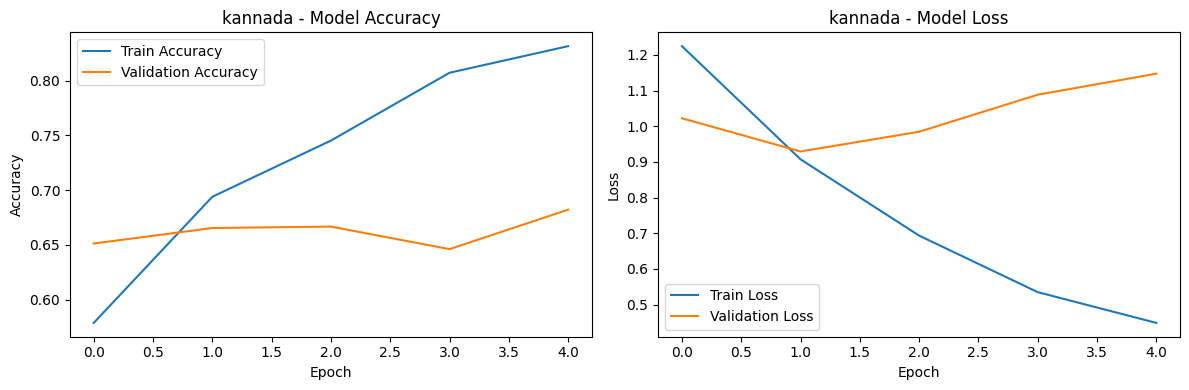

Generating predictions for kannada test set...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predictions saved to offensive_predictions_kannada.csv
Prediction distribution:
Predicted
Not_offensive    544
not-Kannada      234
Name: count, dtype: int64
Data loaded for malayalam
Train shape: (16010, 2)
Dev shape: (1999, 2)
Test shape: (2001, 2)

Label distribution for malayalam:
Labels
Not_offensive                           14153
not-malayalam                            1287
Offensive_Targeted_Insult_Individual      239
Offensive_Untargetede                     191
Offensive_Targeted_Insult_Group           140
Name: count, dtype: int64

Unique labels: ['Not_offensive', 'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual', 'Offensive_Untargetede', 'not-malayalam']
 Preprocessing text for malayalam...
Text preprocessing completed for malayalam
Train samples after cleaning: 16010
Dev samples after cleaning: 1999
Vocabulary size: 30580
Number of classes: 5
Training sequences s

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     3,914,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 46, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 19, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,992,773 (15.23 MB)

 Trainable params: 3,992,773 (15.23 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training cnn model for malayalam...
Epoch 1/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.8719 - loss: 0.5632 - val_accuracy: 0.9265 - val_loss: 0.2673 - learning_rate: 0.0010
Epoch 2/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.9298 - loss: 0.2536 - val_accuracy: 0.9290 - val_loss: 0.2327 - learning_rate: 0.0010
Epoch 3/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.9466 - loss: 0.1547 - val_accuracy: 0.9335 - val_loss: 0.2401 - learning_rate: 0.0010
Epoch 4/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9581 - loss: 0.1073 - val_accuracy: 0.9385 - val_loss: 0.2876 - learning_rate: 0.0010
Epoch 5/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9651 - loss: 0.0827 - val_accuracy: 0.9385 - val_loss: 0.2855 - learning_rate: 0.0010
Training completed for malayalam
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Evaluation Results for malayalam:
Accuracy: 0.9290

Classification Report:
                                      precisio

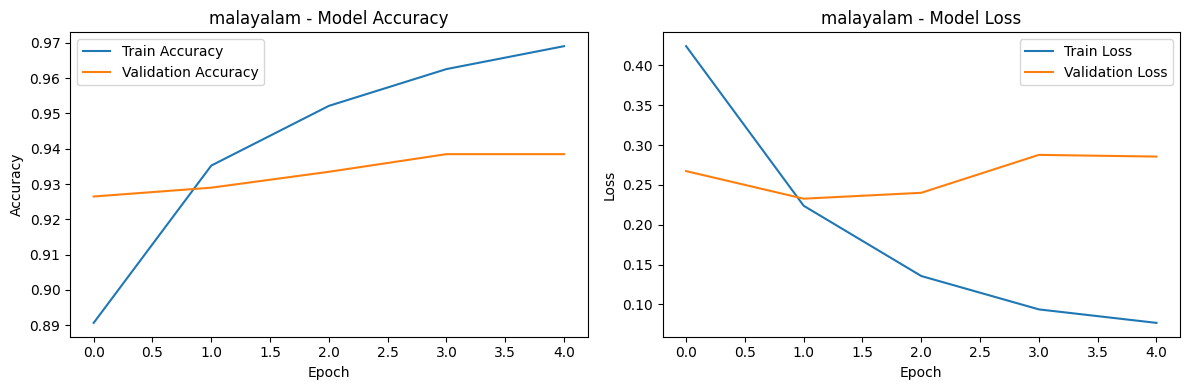

Generating predictions for malayalam test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predictions saved to offensive_predictions_malayalam.csv
Prediction distribution:
Predicted
Not_offensive    1843
not-malayalam     158
Name: count, dtype: int64
Data loaded for tulu
Train shape: (2692, 2)
Dev shape: (577, 2)
Test shape: (576, 2)

Label distribution for tulu:
Labels
not offensive           1261
not tulu                 726
offensive untargeted     462
offensive targeted       243
Name: count, dtype: int64

Unique labels: ['not offensive', 'not tulu', 'offensive targeted', 'offensive untargeted']
 Preprocessing text for tulu...
Text preprocessing completed for tulu
Train samples after cleaning: 2690
Dev samples after cleaning: 577
Vocabulary size: 8482
Number of classes: 4
Training sequences shape: (2690, 100)
Training labels shape: (2690, 4)
 CNN model built and compiled for tulu


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 128)       │     1,085,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 46, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 19, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,164,164 (4.44 MB)

 Trainable params: 1,164,164 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training cnn model for tulu...
Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.4480 - loss: 1.2677 - val_accuracy: 0.5269 - val_loss: 1.0822 - learning_rate: 0.0010
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5515 - loss: 1.0079 - val_accuracy: 0.7140 - val_loss: 0.8056 - learning_rate: 0.0010
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7736 - loss: 0.5889 - val_accuracy: 0.7487 - val_loss: 0.7592 - learning_rate: 0.0010
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8773 - loss: 0.2922 - val_accuracy: 0.7244 - val_loss: 1.0322 - learning_rate: 0.0010
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9242 - loss: 0.2040 - val_accuracy: 0.6967 - val_loss: 1.1910 - learning_rate: 0.0010
Training completed for tulu
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Evaluation Results for tulu:
Accuracy: 0.7487

Classification Report:
                      precision    recall  f1-score   support

       not o

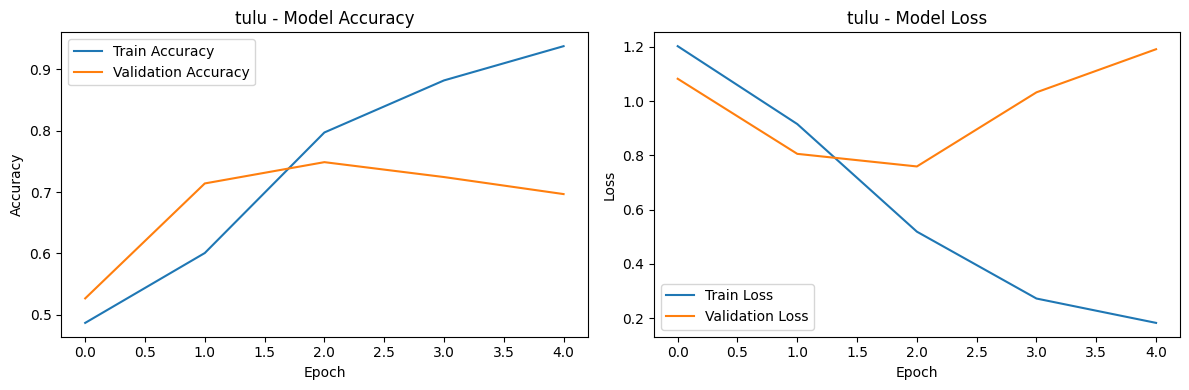

Generating predictions for tulu test set...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predictions saved to offensive_predictions_tulu.csv
Prediction distribution:
Predicted
not offensive           304
offensive untargeted    140
not tulu                132
Name: count, dtype: int64
Data loaded for tamil
Train shape: (35139, 2)
Dev shape: (4388, 2)
Test shape: (4392, 2)

Label distribution for tamil:
Labels
Not_offensive                           25425
Offensive_Untargetede                    2906
Offensive_Targeted_Insult_Group          2557
Offensive_Targeted_Insult_Individual     2343
not-Tamil                                1454
Offensive_Targeted_Insult_Other           454
Name: count, dtype: int64

Unique labels: ['Not_offensive', 'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Tamil']
 Preprocessing text for tamil...
Text preprocessing completed for tamil
Train samples after cleaning: 35138
D

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     8,324,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 46, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 19, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,403,334 (32.06 MB)

 Trainable params: 8,403,334 (32.06 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training cnn model for tamil...
Epoch 1/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 126s 111ms/step - accuracy: 0.7159 - loss: 0.9723 - val_accuracy: 0.7505 - val_loss: 0.7407 - learning_rate: 0.0010
Epoch 2/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 144s 113ms/step - accuracy: 0.7517 - loss: 0.7180 - val_accuracy: 0.7596 - val_loss: 0.7256 - learning_rate: 0.0010
Epoch 3/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 141s 112ms/step - accuracy: 0.7872 - loss: 0.5875 - val_accuracy: 0.7573 - val_loss: 0.8358 - learning_rate: 0.0010
Epoch 4/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 142s 112ms/step - accuracy: 0.8218 - loss: 0.4845 - val_accuracy: 0.7352 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 5/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 143s 113ms/step - accuracy: 0.8534 - loss: 0.4130 - val_accuracy: 0.7441 - val_loss: 1.1472 - learning_rate: 0.0010
Training completed for tamil
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Evaluation Results for tamil:
Accuracy: 0.7596

Classification Report:
                                    

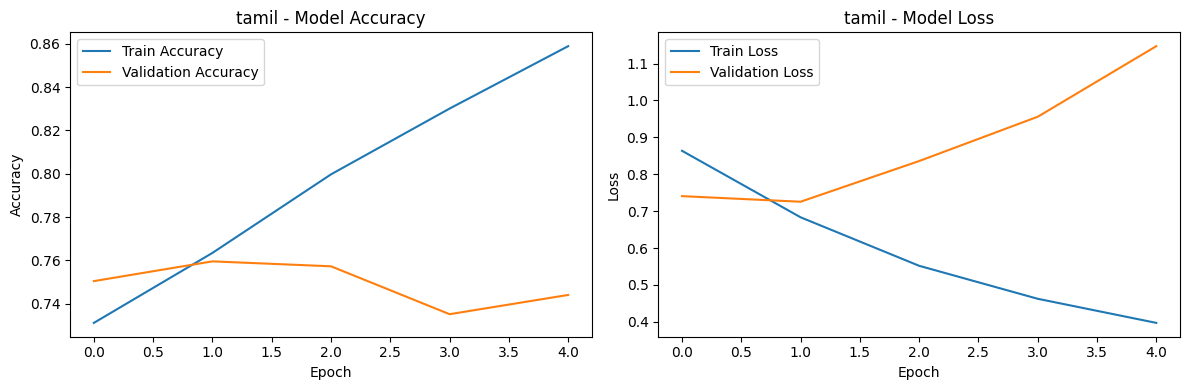

Generating predictions for tamil test set...
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Predictions saved to offensive_predictions_tamil.csv
Prediction distribution:
Predicted
Not_offensive                      3746
Offensive_Untargetede               399
not-Tamil                           125
Offensive_Targeted_Insult_Group     122
Name: count, dtype: int64
kannada: Accuracy = 0.6654
malayalam: Accuracy = 0.9290
tulu: Accuracy = 0.7487
tamil: Accuracy = 0.7596


In [ ]:
results = process_all_languages(
    language_configs=language_configs,
    model_type='cnn',
    epochs=5
)


for language, result in results.items():
    if result['accuracy'] is not None:
        print(f"{language}: Accuracy = {result['accuracy']:.4f}")
    else:
        print(f"{language}: Training failed")

Data loaded for kannada
Train shape: (6217, 2)
Dev shape: (777, 2)
Test shape: (778, 2)

Label distribution for kannada:
Labels
Not_offensive                           3544
not-Kannada                             1522
Offensive_Targeted_Insult_Individual     487
Offensive_Targeted_Insult_Group          329
Offensive_Untargetede                    212
Offensive_Targeted_Insult_Other          123
Name: count, dtype: int64

Unique labels: ['Not_offensive', 'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Kannada']
 Preprocessing text for kannada...
Text preprocessing completed for kannada
Train samples after cleaning: 6217
Dev samples after cleaning: 777
Vocabulary size: 15344
Number of classes: 6
Training sequences shape: (6217, 100)
Training labels shape: (6217, 6)
 LSTM model built and compiled for kannada


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 128)       │     1,964,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,110,502 (8.05 MB)

 Trainable params: 2,110,502 (8.05 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training lstm model for kannada...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 101s 439ms/step - accuracy: 0.5008 - loss: 1.3880 - val_accuracy: 0.6306 - val_loss: 0.9995 - learning_rate: 0.0010
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 417ms/step - accuracy: 0.6481 - loss: 0.9648 - val_accuracy: 0.6808 - val_loss: 0.8955 - learning_rate: 0.0010
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 413ms/step - accuracy: 0.7507 - loss: 0.7386 - val_accuracy: 0.7001 - val_loss: 0.9551 - learning_rate: 0.0010
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 406ms/step - accuracy: 0.8003 - loss: 0.6030 - val_accuracy: 0.6976 - val_loss: 1.0043 - learning_rate: 0.0010
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 84s 415ms/step - accuracy: 0.8236 - loss: 0.5195 - val_accuracy: 0.6834 - val_loss: 1.0347 - learning_rate: 0.0010
Training completed for kannada
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step
Evaluation Results for kannada:
Accuracy: 0.6808

Classification Report:
                                      preci

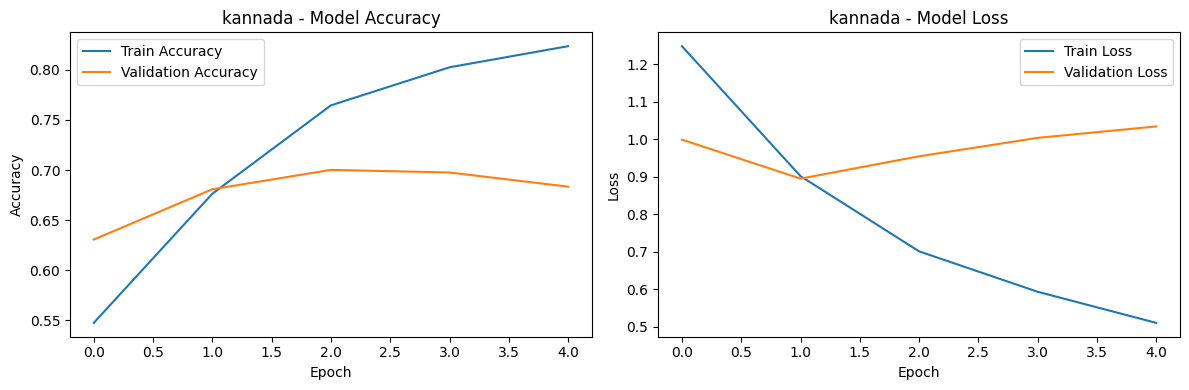

Generating predictions for kannada test set...
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Predictions saved to offensive_predictions_kannada.csv
Prediction distribution:
Predicted
Not_offensive                           417
not-Kannada                             263
Offensive_Targeted_Insult_Individual     98
Name: count, dtype: int64
Data loaded for malayalam
Train shape: (16010, 2)
Dev shape: (1999, 2)
Test shape: (2001, 2)

Label distribution for malayalam:
Labels
Not_offensive                           14153
not-malayalam                            1287
Offensive_Targeted_Insult_Individual      239
Offensive_Untargetede                     191
Offensive_Targeted_Insult_Group           140
Name: count, dtype: int64

Unique labels: ['Not_offensive', 'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual', 'Offensive_Untargetede', 'not-malayalam']
 Preprocessing text for malayalam...
Text preprocessing completed for malayalam
Train samples after cleaning: 16010
Dev sam

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 128)       │     3,914,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,060,677 (15.49 MB)

 Trainable params: 4,060,677 (15.49 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training lstm model for malayalam...
Epoch 1/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 233s 434ms/step - accuracy: 0.8812 - loss: 0.5860 - val_accuracy: 0.9220 - val_loss: 0.2995 - learning_rate: 0.0010
Epoch 2/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 259s 430ms/step - accuracy: 0.9127 - loss: 0.3144 - val_accuracy: 0.9265 - val_loss: 0.2424 - learning_rate: 0.0010
Epoch 3/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 215s 430ms/step - accuracy: 0.9376 - loss: 0.1989 - val_accuracy: 0.9340 - val_loss: 0.2434 - learning_rate: 0.0010
Epoch 4/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 216s 431ms/step - accuracy: 0.9486 - loss: 0.1387 - val_accuracy: 0.9390 - val_loss: 0.2603 - learning_rate: 0.0010
Epoch 5/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 261s 430ms/step - accuracy: 0.9584 - loss: 0.1112 - val_accuracy: 0.9350 - val_loss: 0.2705 - learning_rate: 0.0010
Training completed for malayalam
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step
Evaluation Results for malayalam:
Accuracy: 0.9265

Classification Report:
                                 

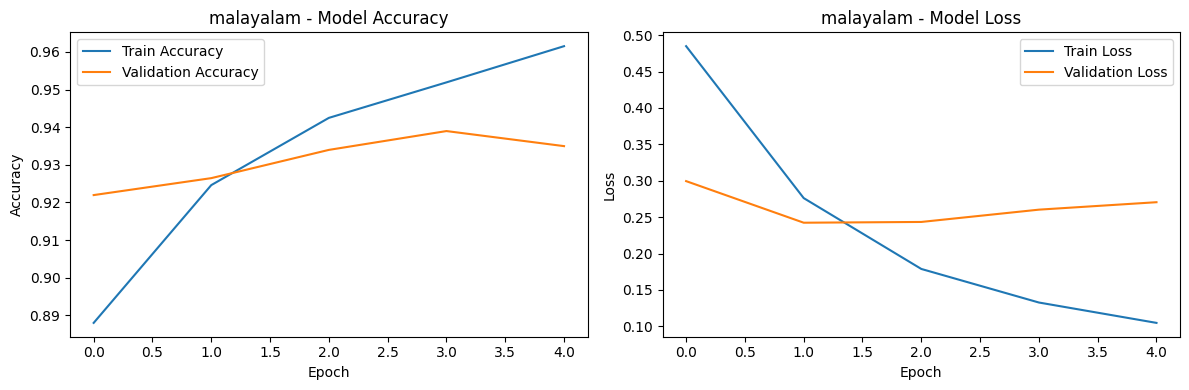

Generating predictions for malayalam test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step
Predictions saved to offensive_predictions_malayalam.csv
Prediction distribution:
Predicted
Not_offensive    1875
not-malayalam     126
Name: count, dtype: int64
Data loaded for tulu
Train shape: (2692, 2)
Dev shape: (577, 2)
Test shape: (576, 2)

Label distribution for tulu:
Labels
not offensive           1261
not tulu                 726
offensive untargeted     462
offensive targeted       243
Name: count, dtype: int64

Unique labels: ['not offensive', 'not tulu', 'offensive targeted', 'offensive untargeted']
 Preprocessing text for tulu...
Text preprocessing completed for tulu
Train samples after cleaning: 2690
Dev samples after cleaning: 577
Vocabulary size: 8482
Number of classes: 4
Training sequences shape: (2690, 100)
Training labels shape: (2690, 4)
 LSTM model built and compiled for tulu


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 128)       │     1,085,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,232,100 (4.70 MB)

 Trainable params: 1,232,100 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training lstm model for tulu...
Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 53s 437ms/step - accuracy: 0.3887 - loss: 1.3060 - val_accuracy: 0.4679 - val_loss: 1.2302 - learning_rate: 0.0010
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 431ms/step - accuracy: 0.5027 - loss: 1.1751 - val_accuracy: 0.5650 - val_loss: 0.9360 - learning_rate: 0.0010
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 433ms/step - accuracy: 0.7167 - loss: 0.7265 - val_accuracy: 0.7331 - val_loss: 0.6529 - learning_rate: 0.0010
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 441ms/step - accuracy: 0.8395 - loss: 0.4469 - val_accuracy: 0.7626 - val_loss: 0.6658 - learning_rate: 0.0010
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 411ms/step - accuracy: 0.8876 - loss: 0.2909 - val_accuracy: 0.7903 - val_loss: 0.7758 - learning_rate: 0.0010
Training completed for tulu
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step
Evaluation Results for tulu:
Accuracy: 0.7331

Classification Report:
                      precision    recall  f1-score   support



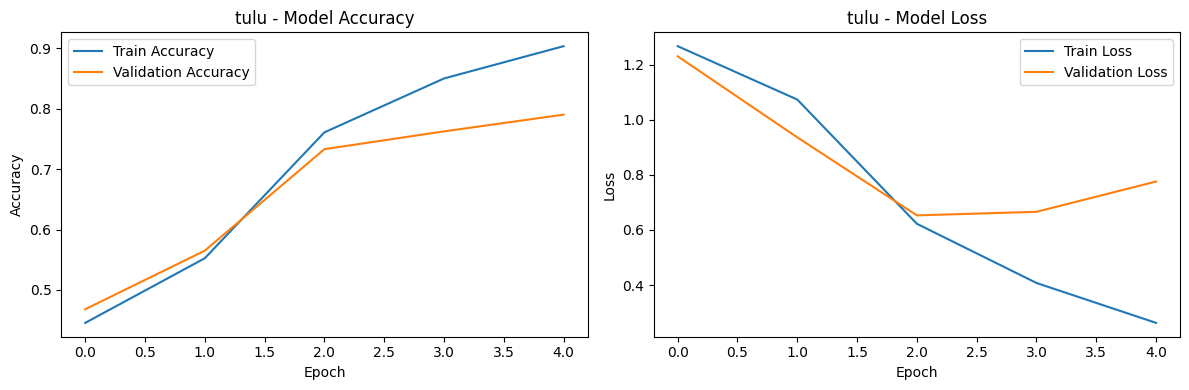

Generating predictions for tulu test set...
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Predictions saved to offensive_predictions_tulu.csv
Prediction distribution:
Predicted
not offensive           249
not tulu                193
offensive untargeted    133
offensive targeted        1
Name: count, dtype: int64
Data loaded for tamil
Train shape: (35139, 2)
Dev shape: (4388, 2)
Test shape: (4392, 2)

Label distribution for tamil:
Labels
Not_offensive                           25425
Offensive_Untargetede                    2906
Offensive_Targeted_Insult_Group          2557
Offensive_Targeted_Insult_Individual     2343
not-Tamil                                1454
Offensive_Targeted_Insult_Other           454
Name: count, dtype: int64

Unique labels: ['Not_offensive', 'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Tamil']
 Preprocessing text for tamil...
Text preprocessing completed for tamil
Train sa

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 128)       │     8,324,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_7             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,206 (32.32 MB)

 Trainable params: 8,471,206 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training lstm model for tamil...
Epoch 1/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 527s 466ms/step - accuracy: 0.6981 - loss: 1.0149 - val_accuracy: 0.7491 - val_loss: 0.7371 - learning_rate: 0.0010
Epoch 2/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 561s 465ms/step - accuracy: 0.7473 - loss: 0.7463 - val_accuracy: 0.7662 - val_loss: 0.6983 - learning_rate: 0.0010
Epoch 3/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 560s 463ms/step - accuracy: 0.7685 - loss: 0.6573 - val_accuracy: 0.7562 - val_loss: 0.7225 - learning_rate: 0.0010
Epoch 4/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 566s 467ms/step - accuracy: 0.7919 - loss: 0.5832 - val_accuracy: 0.7470 - val_loss: 0.7840 - learning_rate: 0.0010
Epoch 5/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 566s 471ms/step - accuracy: 0.8154 - loss: 0.5204 - val_accuracy: 0.7484 - val_loss: 0.9219 - learning_rate: 0.0010
Training completed for tamil
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step
Evaluation Results for tamil:
Accuracy: 0.7662

Classification Report:
                                 

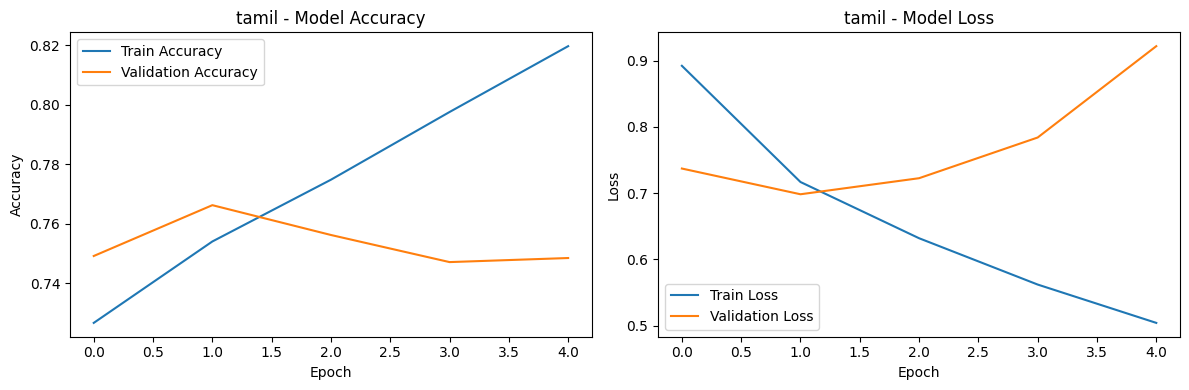

Generating predictions for tamil test set...
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
Predictions saved to offensive_predictions_tamil.csv
Prediction distribution:
Predicted
Not_offensive                      3951
Offensive_Untargetede               303
not-Tamil                           128
Offensive_Targeted_Insult_Group      10
Name: count, dtype: int64
kannada: Accuracy = 0.6808
malayalam: Accuracy = 0.9265
tulu: Accuracy = 0.7331
tamil: Accuracy = 0.7662


In [ ]:
results = process_all_languages(
    language_configs=language_configs,
    model_type='lstm',
    epochs=5
)


for language, result in results.items():
    if result['accuracy'] is not None:
        print(f"{language}: Accuracy = {result['accuracy']:.4f}")
    else:
        print(f"{language}: Training failed")

Data loaded for kannada
Train shape: (6217, 2)
Dev shape: (777, 2)
Test shape: (778, 2)

Label distribution for kannada:
Labels
Not_offensive                           3544
not-Kannada                             1522
Offensive_Targeted_Insult_Individual     487
Offensive_Targeted_Insult_Group          329
Offensive_Untargetede                    212
Offensive_Targeted_Insult_Other          123
Name: count, dtype: int64

Unique labels: ['Not_offensive', 'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Kannada']
 Preprocessing text for kannada...
Text preprocessing completed for kannada
Train samples after cleaning: 6217
Dev samples after cleaning: 777
Vocabulary size: 15344
Number of classes: 6
Training sequences shape: (6217, 100)
Training labels shape: (6217, 6)
 HYBRID model built and compiled for kannada


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 128)       │     1,964,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_8             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 49, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,102,374 (8.02 MB)

 Trainable params: 2,102,374 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training hybrid model for kannada...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - accuracy: 0.4771 - loss: 1.3721 - val_accuracy: 0.6190 - val_loss: 1.0746 - learning_rate: 0.0010
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.6022 - loss: 1.0522 - val_accuracy: 0.6782 - val_loss: 0.9405 - learning_rate: 0.0010
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.7101 - loss: 0.8107 - val_accuracy: 0.6808 - val_loss: 0.9236 - learning_rate: 0.0010
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step - accuracy: 0.7940 - loss: 0.6317 - val_accuracy: 0.6924 - val_loss: 1.0225 - learning_rate: 0.0010
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.8133 - loss: 0.5386 - val_accuracy: 0.6847 - val_loss: 1.0434 - learning_rate: 0.0010
Training completed for kannada
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
Evaluation Results for kannada:
Accuracy: 0.6808

Classification Report:
                                      preci

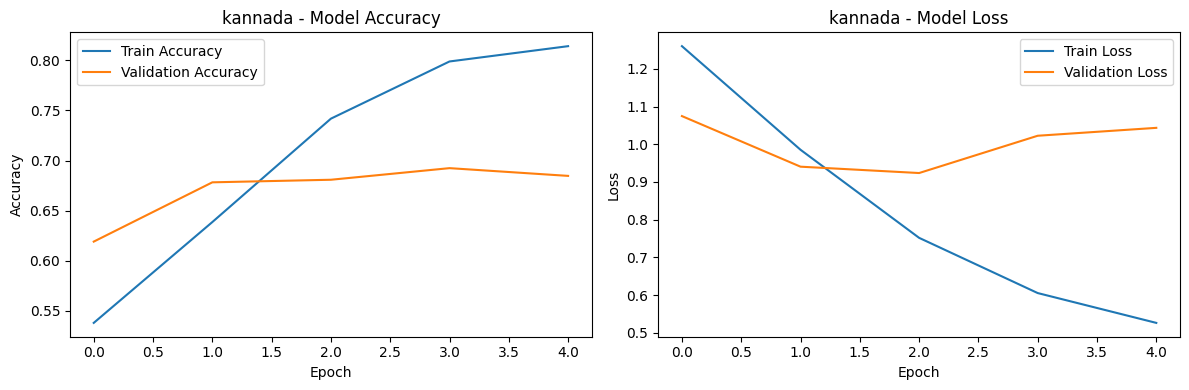

Generating predictions for kannada test set...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Predictions saved to offensive_predictions_kannada.csv
Prediction distribution:
Predicted
Not_offensive                           425
not-Kannada                             266
Offensive_Targeted_Insult_Individual     87
Name: count, dtype: int64
Data loaded for malayalam
Train shape: (16010, 2)
Dev shape: (1999, 2)
Test shape: (2001, 2)

Label distribution for malayalam:
Labels
Not_offensive                           14153
not-malayalam                            1287
Offensive_Targeted_Insult_Individual      239
Offensive_Untargetede                     191
Offensive_Targeted_Insult_Group           140
Name: count, dtype: int64

Unique labels: ['Not_offensive', 'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual', 'Offensive_Untargetede', 'not-malayalam']
 Preprocessing text for malayalam...
Text preprocessing completed for malayalam
Train samples after cleaning: 16010
Dev sam

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 128)       │     3,914,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_9             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 49, 128)        │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,549 (15.46 MB)

 Trainable params: 4,052,549 (15.46 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training hybrid model for malayalam...
Epoch 1/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 78s 139ms/step - accuracy: 0.8660 - loss: 0.6280 - val_accuracy: 0.9270 - val_loss: 0.2907 - learning_rate: 0.0010
Epoch 2/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 70s 139ms/step - accuracy: 0.9200 - loss: 0.3165 - val_accuracy: 0.9295 - val_loss: 0.2575 - learning_rate: 0.0010
Epoch 3/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 81s 138ms/step - accuracy: 0.9402 - loss: 0.2243 - val_accuracy: 0.9360 - val_loss: 0.2628 - learning_rate: 0.0010
Epoch 4/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 82s 139ms/step - accuracy: 0.9502 - loss: 0.1511 - val_accuracy: 0.9280 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 5/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 69s 137ms/step - accuracy: 0.9599 - loss: 0.1089 - val_accuracy: 0.9350 - val_loss: 0.3021 - learning_rate: 0.0010
Training completed for malayalam
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step
Evaluation Results for malayalam:
Accuracy: 0.9295

Classification Report:
                                     

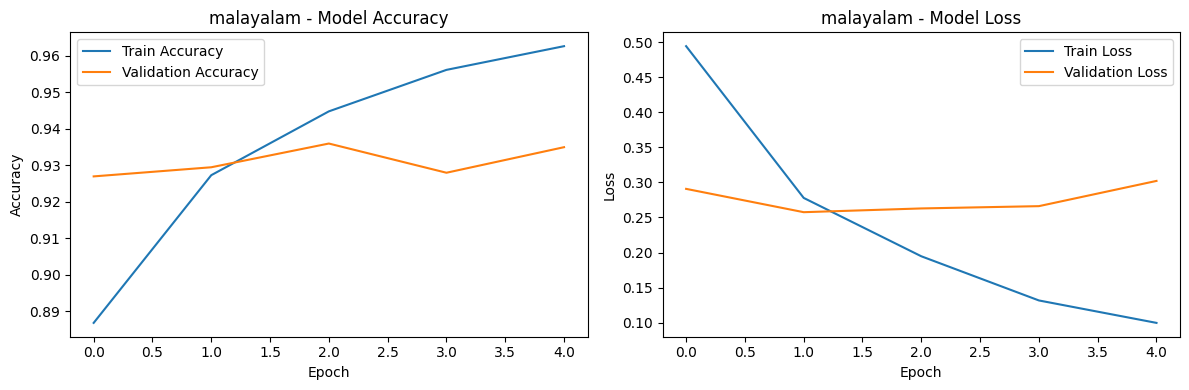

Generating predictions for malayalam test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Predictions saved to offensive_predictions_malayalam.csv
Prediction distribution:
Predicted
Not_offensive    1869
not-malayalam     132
Name: count, dtype: int64
Data loaded for tulu
Train shape: (2692, 2)
Dev shape: (577, 2)
Test shape: (576, 2)

Label distribution for tulu:
Labels
not offensive           1261
not tulu                 726
offensive untargeted     462
offensive targeted       243
Name: count, dtype: int64

Unique labels: ['not offensive', 'not tulu', 'offensive targeted', 'offensive untargeted']
 Preprocessing text for tulu...
Text preprocessing completed for tulu
Train samples after cleaning: 2690
Dev samples after cleaning: 577
Vocabulary size: 8482
Number of classes: 4
Training sequences shape: (2690, 100)
Training labels shape: (2690, 4)
 HYBRID model built and compiled for tulu


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 100, 128)       │     1,085,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_10            │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 49, 128)        │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,223,972 (4.67 MB)

 Trainable params: 1,223,972 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training hybrid model for tulu...
Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.4245 - loss: 1.3012 - val_accuracy: 0.4679 - val_loss: 1.2295 - learning_rate: 0.0010
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.4642 - loss: 1.2167 - val_accuracy: 0.6846 - val_loss: 0.9001 - learning_rate: 0.0010
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.7332 - loss: 0.7359 - val_accuracy: 0.7504 - val_loss: 0.7235 - learning_rate: 0.0010
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.8555 - loss: 0.4070 - val_accuracy: 0.7695 - val_loss: 0.7757 - learning_rate: 0.0010
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.9048 - loss: 0.2892 - val_accuracy: 0.7608 - val_loss: 0.8162 - learning_rate: 0.0010
Training completed for tulu
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Evaluation Results for tulu:
Accuracy: 0.7504

Classification Report:
                      precision    recall  f1-score   support



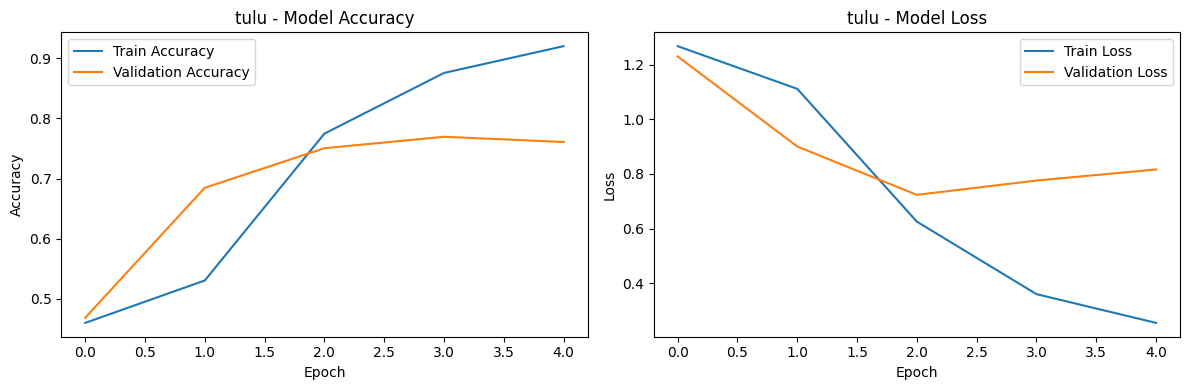

Generating predictions for tulu test set...
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Predictions saved to offensive_predictions_tulu.csv
Prediction distribution:
Predicted
not offensive           271
not tulu                157
offensive untargeted    143
offensive targeted        5
Name: count, dtype: int64
Data loaded for tamil
Train shape: (35139, 2)
Dev shape: (4388, 2)
Test shape: (4392, 2)

Label distribution for tamil:
Labels
Not_offensive                           25425
Offensive_Untargetede                    2906
Offensive_Targeted_Insult_Group          2557
Offensive_Targeted_Insult_Individual     2343
not-Tamil                                1454
Offensive_Targeted_Insult_Other           454
Name: count, dtype: int64

Unique labels: ['Not_offensive', 'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual', 'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Tamil']
 Preprocessing text for tamil...
Text preprocessing completed for tamil
Train sa

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 100, 128)       │     8,324,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_11            │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 49, 128)        │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,463,078 (32.28 MB)

 Trainable params: 8,463,078 (32.28 MB)

 Non-trainable params: 0 (0.00 B)

None
 Training hybrid model for tamil...
Epoch 1/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 201s 175ms/step - accuracy: 0.7097 - loss: 1.0103 - val_accuracy: 0.7427 - val_loss: 0.7517 - learning_rate: 0.0010
Epoch 2/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 190s 172ms/step - accuracy: 0.7448 - loss: 0.7522 - val_accuracy: 0.7555 - val_loss: 0.7323 - learning_rate: 0.0010
Epoch 3/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 203s 173ms/step - accuracy: 0.7653 - loss: 0.6566 - val_accuracy: 0.7527 - val_loss: 0.7856 - learning_rate: 0.0010
Epoch 4/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 204s 175ms/step - accuracy: 0.7938 - loss: 0.5592 - val_accuracy: 0.7370 - val_loss: 0.9182 - learning_rate: 0.0010
Epoch 5/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 192s 175ms/step - accuracy: 0.8198 - loss: 0.4886 - val_accuracy: 0.7329 - val_loss: 0.9400 - learning_rate: 0.0010
Training completed for tamil
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
Evaluation Results for tamil:
Accuracy: 0.7555

Classification Report:
                                

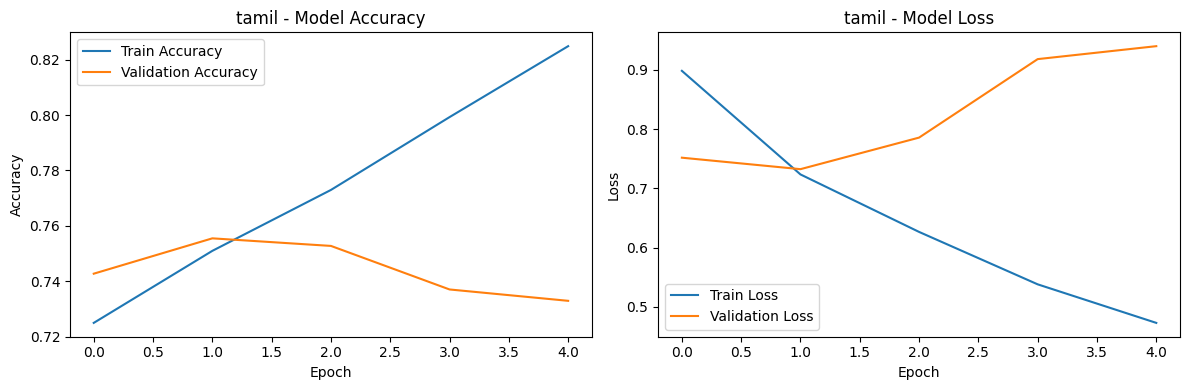

Generating predictions for tamil test set...
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
Predictions saved to offensive_predictions_tamil.csv
Prediction distribution:
Predicted
Not_offensive                           3880
Offensive_Untargetede                    294
not-Tamil                                137
Offensive_Targeted_Insult_Group           77
Offensive_Targeted_Insult_Individual       4
Name: count, dtype: int64
kannada: Accuracy = 0.6808
malayalam: Accuracy = 0.9295
tulu: Accuracy = 0.7504
tamil: Accuracy = 0.7555


In [ ]:
results = process_all_languages(
    language_configs=language_configs,
    model_type='hybrid',
    epochs=5
)
for language, result in results.items():
    if result['accuracy'] is not None:
        print(f"{language}: Accuracy = {result['accuracy']:.4f}")
    else:
        print(f"{language}: Training failed")

In [ ]:
test_file_paths = {
    'kannada': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/kannada_offensive_test_with_labels.csv',
    'malayalam': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/mal_offensive_test_with_labels.csv',
    'tulu': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/tulu_offensive_test_with_labels.csv',
    'tamil': '/content/drive/MyDrive/FIRE-2025/Offensive Language Identification/tamil_offensive_full_test_with_labels.csv'
}

test_data_with_labels = {}
for language, paths in language_configs.items():
    test_path_with_labels = test_file_paths[language]
    try:
        test_data_with_labels[language] = pd.read_csv(test_path_with_labels)
        print(f"Loaded test data with labels for {language}. Shape: {test_data_with_labels[language].shape}")
    except Exception as e:
        print(f"Error loading test data with labels for {language}: {e}")


Loaded test data with labels for kannada. Shape: (778, 3)
Loaded test data with labels for malayalam. Shape: (2001, 3)
Loaded test data with labels for tulu. Shape: (576, 3)
Loaded test data with labels for tamil. Shape: (4392, 3)


In [ ]:
trained_models = {}
for language, result in results.items():
    if 'pipeline' in result and result['pipeline'] is not None:
        trained_models[language] = result['pipeline'].model
        print(f"Accessed trained model for {language}")
    else:
        print(f"No trained pipeline found for {language}")


Accessed trained model for kannada
Accessed trained model for malayalam
Accessed trained model for tulu
Accessed trained model for tamil


In [ ]:
test_predictions = {}

for language, model in trained_models.items():
    if language in results and results[language]['pipeline'] is not None:
        pipeline = results[language]['pipeline']
        X_test = pipeline.X_test

        # Make predictions
        y_pred_proba = model.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Decode predictions to original labels
        predicted_labels = pipeline.data_loader.label_encoder.inverse_transform(y_pred)
        test_predictions[language] = predicted_labels
        print(f"Predictions generated for {language}")

    else:
        print(f"Could not generate predictions for {language}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Predictions generated for kannada
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Predictions generated for malayalam
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predictions generated for tulu
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
Predictions generated for tamil


In [ ]:
from sklearn.metrics import classification_report

for language in language_configs.keys():
    # Check if the hybrid model pipeline exists and test data with labels are loaded
    if language in results and results[language]['pipeline'] is not None and \
       results[language]['pipeline'].model_type == 'hybrid' and \
       language in test_data_with_labels and language in test_predictions:

        # Get true labels
        if language == 'tulu':
            y_true = test_data_with_labels[language]['Label']
        else:
            y_true = test_data_with_labels[language]['Labels']

        # Get predicted labels from the hybrid model's predictions
        y_pred = test_predictions[language]

        print(f"\nClassification Report for {language} (Hybrid Model):")
        print(classification_report(y_true, y_pred))
    else:
        print(f"Skipping classification report for {language} (Hybrid Model): "
              f"Hybrid model pipeline not found, or test data/predictions missing.")


Classification Report for kannada (Hybrid Model):
                                      precision    recall  f1-score   support

                       Not_offensive       0.77      0.76      0.77       427
     Offensive_Targeted_Insult_Group       0.00      0.00      0.00        44
Offensive_Targeted_Insult_Individual       0.51      0.59      0.54        75
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00        14
               Offensive_Untargetede       0.00      0.00      0.00        33
                         not-Kannada       0.61      0.87      0.71       185

                            accuracy                           0.68       778
                           macro avg       0.31      0.37      0.34       778
                        weighted avg       0.61      0.68      0.64       778


Classification Report for malayalam (Hybrid Model):
                                      precision    recall  f1-score   support

                       Not_offensi